In [1]:
import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import matplotlib.pyplot as plt 
from PIL import Image , ImageDraw 
from sklearn.preprocessing import * 
import time 
import ast 
import os 
import keras 
import tensorflow as tf 
from keras import models, layers 
from keras import Input 
from keras.models import Model, load_model 
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers, initializers, regularizers, metrics 
from keras.callbacks import ModelCheckpoint, EarlyStopping 
from keras.layers import BatchNormalization, Conv2D, Activation , AveragePooling2D , Input ,Dropout 
from keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add, Flatten 
from keras.models import Sequential 
from keras.metrics import top_k_categorical_accuracy 
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping 
from keras.applications import ResNet50, vgg19,mobilenet_v2,InceptionV3 , InceptionResNetV2,DenseNet169 
from tqdm import tqdm 
import cv2

In [4]:
path ='C:/Users/sdf80/Desktop/fruit_dataset2/Direction2/'
filename = os.listdir(path)
datalist = pd.DataFrame(data=[], columns=['label','img'])

label = []
img = []

for file in tqdm(filename):
    label.append(file.split('.')[0])
    img.append(file)
    
datalist['label'] = label
datalist['img'] = img

datalist.head()

100%|██████████████████████████████████████████████████████████████████████████| 1094/1094 [00:00<00:00, 365448.28it/s]


,label,img
0,Back,Back.0.jpg
1,Back,Back.1.jpg
2,Back,Back.10.jpg
3,Back,Back.100.jpg
4,Back,Back.101.jpg


No handles with labels found to put in legend.


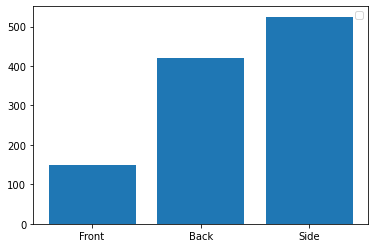

In [5]:
FrontNum = 0
BackNum = 0
SideNum = 0

for i in datalist['label']:
    if i == 'Front':
        FrontNum += 1
    if i == 'Back':
        BackNum += 1
    if i == 'Side':
        SideNum += 1
        
plt.bar(['Front','Back', 'Side'], [FrontNum, BackNum, SideNum])
plt.legend()

In [9]:
def preprocessing(path) :
    X = []
    Y = []
    class_label = []
    class_num = 3
    
    for num in tqdm(range(len(datalist['img']))) :
        img = cv2.imread(path+datalist['img'][num])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(160,160))
        
        if datalist['label'][num] == 'Front': 
            X.append(img) 
            Y.append(0) 
        elif  datalist['label'][num] == 'Back': 
            X.append(img) 
            Y.append(1)
        else:
            X.append(img) 
            Y.append(2)

    tmpx = np.array(X) 
    Y = np.array([[i] for i in Y]) 
    enc = OneHotEncoder(categories='auto') 
    enc.fit(Y) 
    tmpy = enc.transform(Y).toarray() 

    del X 
    del Y #RAM메모리 절약을 위해 사용하지 않는 변수 삭제
    return tmpx , tmpy , class_label , class_num

In [10]:
tmpx, tmpy, class_label, class_num = preprocessing(path) 
#파일이름이 담긴 배열 
print(tmpx.shape, tmpy.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 1094/1094 [00:01<00:00, 626.59it/s]

(1094, 160, 160, 3) (1094, 3)


In [11]:
from sklearn.model_selection import train_test_split 
X_train, X_val, Y_train, Y_val = train_test_split(tmpx,tmpy, test_size = 0.2,random_state = 1) 
del tmpx 
del tmpy #RAM메모리 절약을 위해 사용하지 않는 변수 삭제 

print(X_train.shape,X_val.shape,Y_train.shape,Y_val.shape)

(875, 160, 160, 3) (219, 160, 160, 3) (875, 3) (219, 3)


In [12]:
nb_train_samples = len(X_train) 
nb_validation_samples = len(X_val) 
batch_size = 16 
train_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True) 

val_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True) 

train_generator = train_datagen.flow(np.array(X_train), Y_train, batch_size=batch_size) 
validation_generator = val_datagen.flow(np.array(X_val), Y_val, batch_size=batch_size)

In [13]:
model = Sequential()

model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(160,160, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(16,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 158, 8)       224       
_________________________________________________________________
batch_normalization (BatchNo (None, 158, 158, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 79, 79, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 77, 77, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 16)        0

In [15]:
learning_rate = 0.0005


model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=50,
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    )

Epoch 1/50
54/54 [==============================] - 23s 424ms/step - loss: 0.1895 - accuracy: 0.9232 - val_loss: 35.8867 - val_accuracy: 0.4423
Epoch 2/50
54/54 [==============================] - 23s 420ms/step - loss: 0.2148 - accuracy: 0.9243 - val_loss: 26.3851 - val_accuracy: 0.3846
Epoch 3/50
54/54 [==============================] - 23s 419ms/step - loss: 0.2002 - accuracy: 0.9267 - val_loss: 21.7284 - val_accuracy: 0.4183
Epoch 4/50
54/54 [==============================] - 22s 416ms/step - loss: 0.1853 - accuracy: 0.9173 - val_loss: 12.7791 - val_accuracy: 0.5240
Epoch 5/50
54/54 [==============================] - 23s 426ms/step - loss: 0.1993 - accuracy: 0.9243 - val_loss: 5.4249 - val_accuracy: 0.5962
Epoch 6/50
54/54 [==============================] - 22s 415ms/step - loss: 0.1652 - accuracy: 0.9464 - val_loss: 8.6085 - val_accuracy: 0.6298
Epoch 7/50
54/54 [==============================] - 23s 418ms/step - loss: 0.1871 - accuracy: 0.9313 - val_loss: 4.6053 - val_accuracy: 0.

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

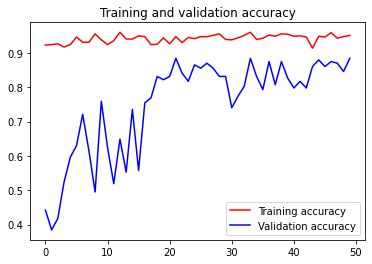

<Figure size 432x288 with 0 Axes>

In [19]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [20]:
from keras.models import load_model

model.save('Fruit_Direction_model2.h5')